In [1]:
# Dependencies
import re
import json
import enchant
import wordninja
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.dataset.tweets import Tweets 

%matplotlib inline

years = [2017, 2018, 2019]
EN_DICT = enchant.Dict("en_US")

# Hashatag analysis

## Whole dataset

In [2]:
# Initialize Tweets class
tweets = Tweets()
# Fill tweets dataframe
tweets.from_json('data/db/tweets.json')

tweets.df.head()

,tweet_id,tweet_date,tweet_text
0,836950901495631872,2017-03-01 14:46:59,TT SINGAPORE 22:46\n1.Hong Kong\n2.#JointAddre...
1,836950882528989184,2017-03-01 14:46:54,Letting #snapchat prepare me for the day's uns...
2,836950869639835649,2017-03-01 14:46:51,"""The bill would require the state to get all o..."
3,836950847380668416,2017-03-01 14:46:46,Style-Lead don't Follow #recycledfashion https...
4,836950839101116421,2017-03-01 14:46:44,‘Shell knew’: oil giant's 1991 film warned of ...


In [3]:
# Compute hashtags occurrences (dict {text : occurrences})
hash_counts = {}
for y in years: 
    hash_counts[y] = tweets.get_hashtag_counts(mask = tweets.df.tweet_date.dt.year == y)

In [4]:
# Plot function for hashtag occurrences
def plot_hashtags_occurrences(counts, year, n_hash_min = 0, n_hash_max = 20):
    # Convert the dictionary in a df, sort it by frequency
    hash_df = pd.DataFrame.from_dict(counts.items())
    hash_df.columns = ["hashtag", "occurrences"]
    hash_df.sort_values(by="occurrences", ascending=False, inplace=True)

    # Plot the barplot with the specified interval of the most frequent hashtags
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    ax.set_title("Hashtag occurrences for {}'s tweets".format(year), fontsize=15)
    hash_df[n_hash_min : n_hash_max].plot(x="hashtag", y="occurrences", kind="bar", ax = ax)

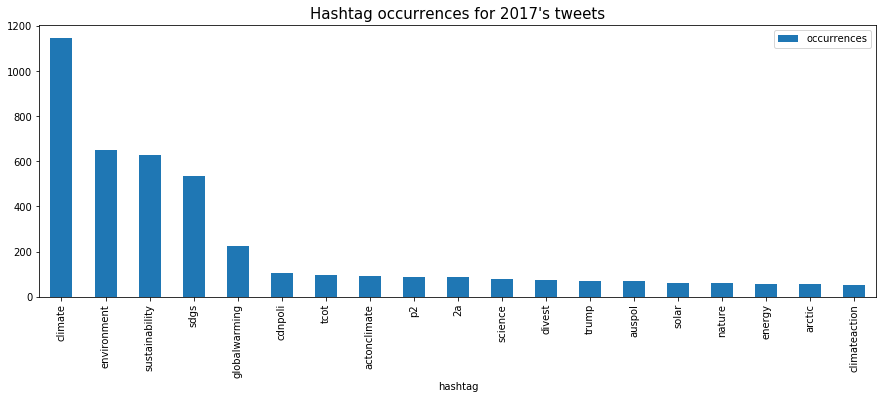

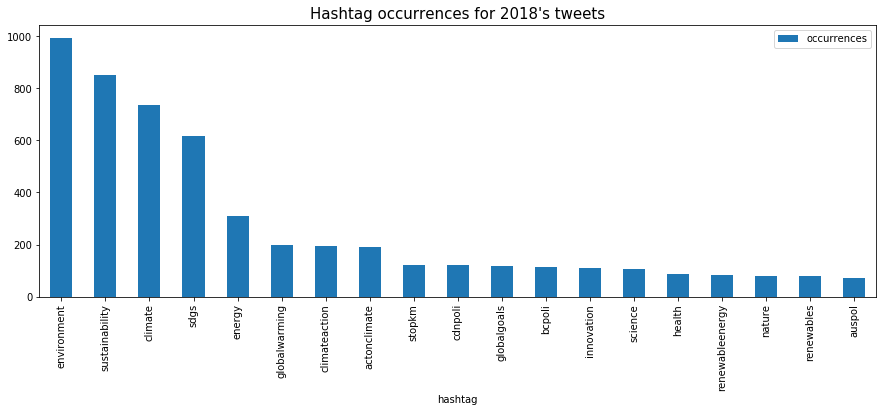

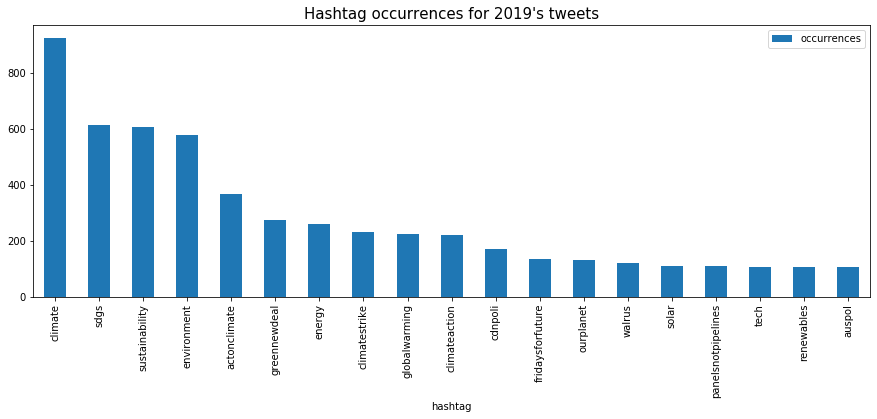

In [5]:
# Show hashtag occurences (without climatechange, too high)
for y in years:
    plot_hashtags_occurrences(hash_counts[y], y, n_hash_min = 1)

### Split hashtags

In [6]:
hashtags = list( set(hash_counts[2017].keys()) | set(hash_counts[2018].keys()) | set(hash_counts[2019].keys()))
splittable_words = {}

for i, hashtag in enumerate(hashtags):
    # define the list of words obtained by splitting the hashtag
    hashtag_splitted = wordninja.split(hashtag)
    # check if the split consists in more than one word
    if (len(hashtag_splitted) > 1) and all([EN_DICT.check(word) for word in hashtag_splitted]):
        # save the word and the suggested splitting
        splittable_words[i] = [ hashtag,
                                ' '.join(hashtag_splitted),
                                hash_counts[2018].get(hashtag, 0),
                                hash_counts[2019].get(hashtag, 0)
                              ]
    else:
        # save the word with a None
        splittable_words[i] = [ hashtag,
                                pd.np.nan,
                                hash_counts[2018].get(hashtag, 0),
                                hash_counts[2019].get(hashtag, 0)
                              ]

splittable_words = pd.DataFrame.from_dict(splittable_words,
                        orient='index',
                        columns=["word", "split", "count_pre", "count_post"])

print(splittable_words.head())
# splittable_words.to_csv('./data/splittable_words.tsv',sep='\t')

                     word                      split  count_pre  count_post
0    ecosystemrestoration      ecosystem restoration          0           1
1                  travel                        NaN         16          16
2  thefutureisprogressive  the future is progressive          1           0
3                  course                        NaN          0           0
4                     oh7                       oh 7          1           0


### Select most frequent hashtag to be splitted manually

In [7]:
# Join top_hash pre and post
top_hash = pd.DataFrame.from_dict(hash_counts[2018], orient='index', columns=['occurrences']).join(
           pd.DataFrame.from_dict(hash_counts[2019], orient='index', columns=['occurrences']), 
           how="outer", lsuffix="_pre", rsuffix="_post")

# Remove nans and sum occurrences
top_hash[top_hash.isna()] = 0
top_hash["occurrences"] = top_hash.occurrences_pre + top_hash.occurrences_post
top_hash = pd.DataFrame(top_hash["occurrences"])

# Join top_hash pre and post
top_hash = top_hash.join(
           pd.DataFrame.from_dict(hash_counts[2017], orient='index', columns=['occurrences']), 
           how="outer", lsuffix="_pre", rsuffix="_post")

# Remove nans and sum occurrences
top_hash[top_hash.isna()] = 0
top_hash["occurrences_tot"] = top_hash.occurrences_pre + top_hash.occurrences_post

# Format (and save) the splitted dataset for the top hashtags
top_splitted = splittable_words.join(top_hash, on="word", how="right")

# Sort the hashtags according to frequency
top_splitted = top_splitted.sort_values(by="occurrences_tot", ascending=False)

# Remove useless columns
top_splitted = top_splitted[["word", "split"]].reset_index(drop=True)

In [8]:
top_splitted[top_splitted.split.isna()].shape

(6382, 2)

In [9]:
# Add hashtag symbol to the texts
top_splitted.loc[:,'word'] = top_splitted.word.apply(lambda x: '#' + x )

# Load old splits
old_split = {} # manually curated
with open('data/hashtag_subs.json', 'r') as file:
    old_split = {**old_split, **json.load(file)}
old_split = pd.DataFrame.from_dict(old_split, orient = 'index').reset_index().rename(columns = {'index':'word', 0:'split'})

In [10]:
# Function to substitute already-manually-curated hashtags
def sub(row):
    if row.word in list(old_split.word.values):
        row.split = ''.join(old_split.split[old_split.word == row.word].values)
    return row

top_splitted = top_splitted.apply(sub, axis = 1)
top_splitted.head()

,word,split
0,#climatechange,climate change
1,#climate,climate
2,#environment,environment
3,#sustainability,sustainability
4,#sdgs,sustainable development goals


In [11]:
top_splitted[top_splitted.split.isna()].shape

(4763, 2)

In [12]:
# Select and save top 600 frequent values
bottom_splitted = top_splitted[600:]
top_splitted = top_splitted[:600]
# top_splitted.to_csv("data/top_600_hashtags_raw.tsv", sep='\t')

# Then the hashtags are manually curated and saved in data/hashtags_sub.json'

In [13]:
split = pd.read_csv("data/top_600_hashtags.tsv", sep='\t', index_col = 0)
split.head()

,word,split
0,#climatechange,climate change
1,#climate,climate
2,#environment,environment
3,#sustainability,sustainability
4,#sdgs,sustainable development goals


In [14]:
split = pd.concat([split, bottom_splitted], ignore_index = True).fillna('')
split.head()

,word,split
0,#climatechange,climate change
1,#climate,climate
2,#environment,environment
3,#sustainability,sustainability
4,#sdgs,sustainable development goals


In [15]:
split_dict = {}

def foo(x, d = split_dict):
    d[x.word] = x.split

split.apply(foo, axis = 1)

split_dict

{'#climatechange': 'climate change',
 '#climate': 'climate',
 '#environment': 'environment',
 '#sustainability': 'sustainability',
 '#sdgs': 'sustainable development goals',
 '#actonclimate': 'act on climate',
 '#globalwarming': 'global warming',
 '#energy': 'energy',
 '#climateaction': 'climate action',
 '#cdnpoli': 'canadian politics',
 '#greennewdeal': 'green new deal',
 '#science': 'science',
 '#auspol': 'australian politics',
 '#solar': 'solar',
 '#renewables': 'renewables',
 '#climatestrike': 'climate strike',
 '#innovation': 'innovation',
 '#nature': 'nature',
 '#renewableenergy': 'renewable energy',
 '#globalgoals': 'global goals',
 '#tech': 'tech',
 '#health': 'health',
 '#keepitintheground': 'keep it in the ground',
 '#bcpoli': 'british columbia politics',
 '#pollution': 'pollution',
 '#fridaysforfuture': 'fridays for future',
 '#water': 'water',
 '#stopkm': 'stop kinder morgan',
 '#ourplanet': 'our planet',
 '#nokxl': 'no keystone XL pipeline',
 '#green': 'green',
 '#p2': 'p

In [16]:
import json

with open('data/hashtag_subs.json', 'w') as fp:
    json.dump(split_dict, fp)